<a href="https://colab.research.google.com/github/hariseldon99/msph402b/blob/main/Ordinary_Differential_Equations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Examples for Ordinary Differential Equations (Initial Value Problem)
===============================================

## Part 1

### Suggestion

Run the code cell below before the others to make sure that scipy is up to date and the figures render well.

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['font.size'] = 20
!pip3 install --upgrade scipy

**The Damped Harmonic Oscillator**

### The Problem

Use the $rk23$ (Second order Runge-Kutta) method and plot a solution $x(t)$ for the damped harmonic oscillator, described by the differential equations

\begin{equation}
\frac{d^2x}{dt^2} + \gamma\frac{dx}{dt} + x = 0.
\end{equation}

Also, obtain phase space plots for some values of $\gamma$.

We can recast the equation above in terms of the phase space point $y = \left[y_0, y_1\right] = \left[x, \dot{x}\right]$, yielding

\begin{align*}
\dot{y}_0 &= y_1\\
\dot{y}_1 &= -y_0 - \gamma y_1
\end{align*}

The code cell below has code that uses 'solve_ivp' routine in the 'scipy.integrate' module to solve the dynamics from $y_0=1, y_1=0$ at $t=0$. The next code cell plots the phase space, $y_1$ vs $y_0$, for a numpy grid of initial conditions.

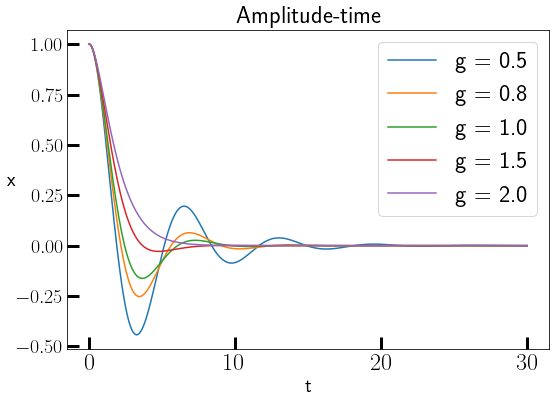

In [6]:
import numpy as np
from scipy.integrate import solve_ivp


def func(t, y, g):
    y0, y1 = y
    dy0dt = y1 
    dy1dt = -y0 - g * y1
    return np.array([dy0dt, dy1dt])


y_init = [1.0, 0.0]
t_final = 30
times = np.linspace(0.0, t_final, 1000)

plt.title("Amplitude-time")
plt.xlabel('t')
plt.ylabel('x', rotation=0)
gammas = [0.5, 0.8, 1.0, 1.5, 2.0]
for g in gammas:
    soln = solve_ivp(func, (0, t_final), y_init, t_eval=times, method='RK23',\
                     args=(g,))
    plt.plot(times, soln.y[0], label=f'g = {g:1.1f}')
    
plt.legend()   

plt.show()

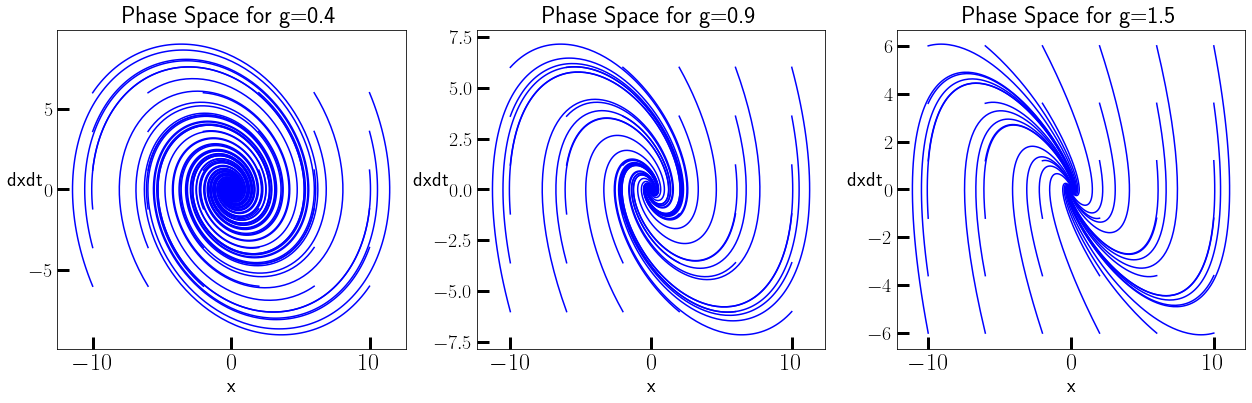

CPU times: user 1.29 s, sys: 18.5 ms, total: 1.31 s
Wall time: 1.33 s


In [8]:
%%time
import matplotlib.pyplot as plt
gammas = [0.4, 0.9, 1.5]
t_final = 30
times = np.linspace(0.0, t_final, 1000)

# Grid of initial conditions, recast as an iterable object 'ics'
y0m, y0mx = -10, 10
y1m, y1mx = -6, 6
Y0, Y1 = np.mgrid[y0m:y0mx:6j, y1m:y1mx:6j]
ics = np.vstack([Y0.ravel(), Y1.ravel()]).T

def func(t, y, g):
    y0, y1 = y
    dy0dt = y1 
    dy1dt = -y0 - g * y1
    return np.array([dy0dt, dy1dt])


plt.rcParams['figure.figsize'] = (len(gammas)*6,6)
for i,g in enumerate(gammas):
    plt.subplot(1,len(gammas),i+1)
    plt.title(f"Phase Space for g={g:1.1f}")
    plt.xlabel('x')
    plt.ylabel('dxdt', rotation=0)
    for p in ics:
        soln = solve_ivp(func, (0, t_final), p, t_eval=times, method='RK23',\
                         args=(g,))
        plt.plot(soln.y[0], soln.y[1], "b-")

plt.show()

**The Driven Oscillator with Damping**

### The Problem

Consider the previous problem, but add a forced external oscillation:

\begin{equation}
\frac{d^2x}{dt^2} + \gamma\frac{dx}{dt} + x = x_0\sin{\omega t}.
\end{equation}

We can recast the equation above in terms of the phase space point $y = \left[y_0, y_1\right] = \left[x, \dot{x}\right]$, yielding

\begin{align*}
\dot{y}_0 &= y_1\\
\dot{y}_1 &= -y_0 - \gamma y_1 + x_0\sin{\omega t}
\end{align*}

Use the general $rk45$ integrator to obtain plots of the amplitude as a function of time for different driving frequencies $\omega$. Plot the root mean-squared amplitude (taken over very long times) as a function of $\omega$ and show that there is a resonance. Compare the runtimes of a trial with the older $rk23$ method and the stiffness-detecting implicit $LSODA$ method, keeping the same error bounds for both. Finally, you can experiment with the driving term by replacing the sine wave with a square wave and see what happens.

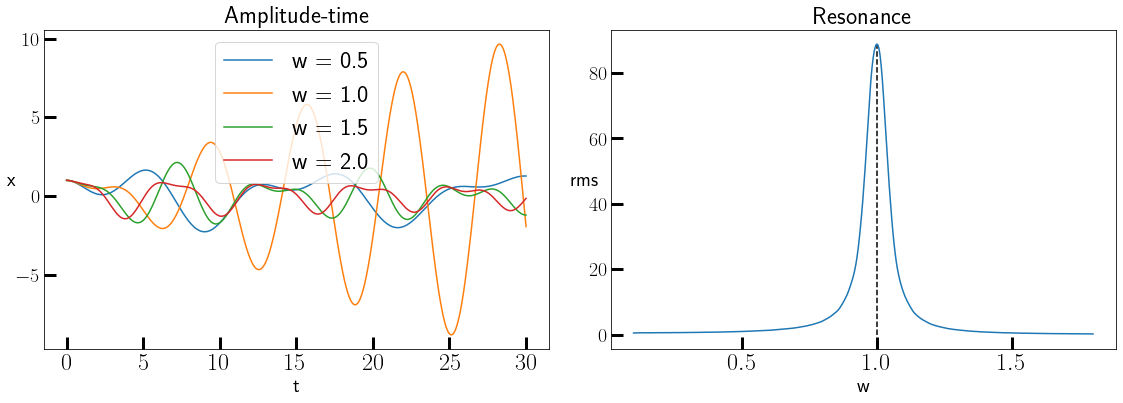

In [10]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16,6)
from scipy.integrate import solve_ivp
from scipy.signal import square

x0 = 1
g = 0.05
y_init = [1.0, 0.0]


def func(t, y, g, x0, w):
    y0, y1 = y
    dy0dt = y1 
    dy1dt = -y0 - g * y1 + x0 * np.sin(w * t)
    # dy1dt = -y0 - g * y1 + x0 * square(w * t)
    return np.array([dy0dt, dy1dt])


plt.subplot(1,2,1)
plt.title("Amplitude-time")
plt.xlabel('t')
plt.ylabel('x', rotation=0)
omegas = [0.5, 1.0, 1.5, 2.0]
t_final = 30
times = np.linspace(0.0, t_final, 1000)

for w in omegas:
    soln = solve_ivp(func, (0, t_final), y_init, t_eval=times, method='RK45',\
                     args=(g,x0, w))
    plt.plot(times, soln.y[0], label=f'w = {w:1.1f}')

plt.legend()

plt.subplot(1,2,2)
plt.title("Resonance")
plt.xlabel('w')
plt.ylabel('rms', rotation=0)

omegas = np.linspace(0.1, 1.8, 400)
rms = np.zeros_like(omegas)

t_final = 100
times = np.linspace(0.0, t_final, 4000)
for i,w in enumerate(omegas):
    soln = solve_ivp(func, (0, t_final), y_init, t_eval=times, method='RK45',\
                     args=(g,x0, w))
    rms[i] = np.average(np.abs(soln.y[0])**2) - np.average(soln.y[0])**2

plt.vlines(1.0, 0.0, np.amax(rms),colors='black', linestyles='dashed')
plt.plot(omegas, rms)
plt.show()

In [ ]:
x0 = 1
g = 0.05
y_init = [1.0, 0.0]
w = 0.6
t_final = 50
times = np.linspace(0, t_final, 1000)

print("Runtimes for rk23:")
%timeit soln = solve_ivp(func, (0, t_final), y_init, t_eval=times, method='RK23',\
                         args=(g,x0, w), rtol=1e-5, atol=1e-8)
print("\nRuntimes for rk45:")
%timeit soln = solve_ivp(func, (0, t_final), y_init, t_eval=times, method='RK45',\
                         args=(g,x0, w), rtol=1e-5, atol=1e-8)
print("\nRuntimes for lsoda:")
%timeit soln = solve_ivp(func, (0, t_final), y_init, t_eval=times, method='LSODA',\
                         args=(g,x0, w), rtol=1e-5, atol=1e-8)

Runtimes for rk23:
1 loop, best of 5: 223 ms per loop

Runtimes for rk45:
10 loops, best of 5: 120 ms per loop

Runtimes for lsoda:
10 loops, best of 5: 54.7 ms per loop


**Simulating Dynamics with Stiffness**

### The Problem:
An ordinary differential equation problem is stiff if the solution being sought is varying slowly, but there are nearby solutions that vary rapidly, so the numerical method must take small steps to obtain satisfactory results.

Stiffness is an efficiency issue. If we weren't concerned with how much time a computation takes, we wouldn't be concerned about stiffness. Nonstiff methods can solve stiff problems; they just take a long time to do it.

A model of flame propagation provides an example. When you light a match, the ball of flame grows rapidly until it reaches a critical size. Then it remains at that size because the amount of oxygen being consumed by the combustion in the interior of the ball balances the amount available through the surface. The simple model is

\begin{equation*}
\frac{dy}{dt} = y^2-y^3,
\end{equation*}

with initial condition $y(0)=\delta$, evolving for times $0<t<2/\delta$.

The scalar variable  $y(t)$ represents the radius of the ball. The  $y^2$ and  $y^3$  terms come from the surface area and the volume. The critical parameter is the initial radius, $\delta$ , which is "small." We seek the solution over a length of time that is inversely proportional to $\delta$.

We will start with the $RK45$ routine. If $\delta$ is not very small, the problem is not very stiff. Let us set  $\delta=0.01$  and request a relative error of $10^{-4}$ and see what we get.

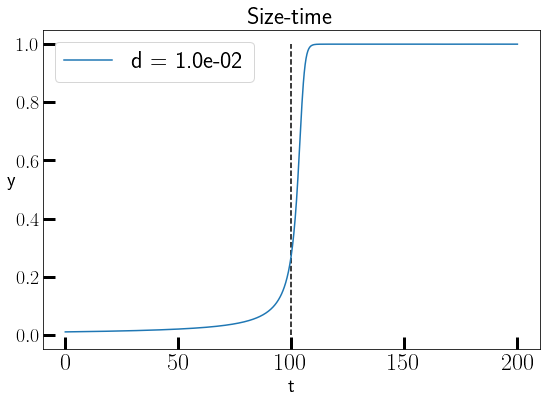

In [11]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8,6)

def radius(initsize, **kwargs):
    t_final = 2.0/initsize
    times = np.linspace(0.0, t_final, 1000)
    return solve_ivp(lambda t,y: y**2 * (1-y), (0, t_final), [initsize],\
                     t_eval=times, **kwargs)
    
d = 0.01
data = radius(d, method='RK45', rtol=1e-4)
plt.title("Size-time")
plt.xlabel('t')
plt.ylabel('y', rotation=0)
plt.plot(data.t, data.y[0], label=f'd = {d:1.1e}')
plt.vlines(1/d, 0.0, np.amax(data.y[0]),colors='black', linestyles='dashed')
plt.legend()   
plt.show()

Now let's see stiffness in action. Decrease $\delta$ by a couple of orders of magnitude and measure the execution time. Compare the execution times of $RK45$ with the stiffness-detecting $LSODA$ method for both the stiff and non-stiff cases.

#### Suggestion

To expedite the execution of the $LSODA$ algorithm, add a routine for computing the Jacobian of the RHS. In this particular case, the Jacobian is simply

\begin{equation*}
J = \frac{d}{dy}\left(y^2-y^3\right)=2y-3y^2
\end{equation*}

In [ ]:
print("Non-Stiff Case -")
d2 = 1e-1
print("RK45:")
%timeit radius(d2, method='RK45', rtol=1e-4)
print("LSODA:")
%timeit radius(d2, method='LSODA', rtol=1e-4)
print("\nStiff Case -")
d2 = 1e-4
print("RK45:")
%timeit radius(d2, method='RK45', rtol=1e-4)
print("LSODA sans Jacobian:")
%timeit radius(d2, method="LSODA", rtol=1e-4)
print("LSODA:")
%timeit radius(d2, method='LSODA', rtol=1e-4, jac=lambda t,y: y*(2-3*y))

Non-Stiff Case -
RK45:
100 loops, best of 5: 3.08 ms per loop
LSODA:
100 loops, best of 5: 3.09 ms per loop

Stiff Case -
RK45:
1 loop, best of 5: 404 ms per loop
LSODA sans Jacobian:
100 loops, best of 5: 5.98 ms per loop
LSODA:
100 loops, best of 5: 5.73 ms per loop
